# Vehicle Loan Prediction Machine Learning Model

# Chapter 7 - Random Forest

### Recap and Load
- As always, let's begin by importing our libraries and loading the data
- Notice that we are importing RandomForestClassifier from sklearn.ensemble

*Throughout this chapter you may see slightly different results to those on the demo videos. The outputs vary due to the random nature of the random forest algorithm but they should be similar to those in the videos*

*Some of the models we will build here are a bit more complex, if you are running into memory related issues try and free up memory by closing down any programs that you do not need to complete the chapter*

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, recall_score, roc_curve, auc, precision_score, ConfusionMatrixDisplay

In [26]:
loan_df = pd.read_csv('vehicle_loans_feat.csv', index_col='UNIQUEID')

In [27]:
loan_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 233154 entries, 420825 to 630213
Data columns (total 31 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   DISBURSED_AMOUNT                     233154 non-null  float64
 1   ASSET_COST                           233154 non-null  float64
 2   LTV                                  233154 non-null  float64
 3   MANUFACTURER_ID                      233154 non-null  int64  
 4   EMPLOYMENT_TYPE                      233154 non-null  object 
 5   STATE_ID                             233154 non-null  int64  
 6   AADHAR_FLAG                          233154 non-null  int64  
 7   PAN_FLAG                             233154 non-null  int64  
 8   VOTERID_FLAG                         233154 non-null  int64  
 9   DRIVING_FLAG                         233154 non-null  int64  
 10  PASSPORT_FLAG                        233154 non-null  int64  
 11  PERFORM_CNS_S

Just like we did for Logistic Regression let's convert our categorical variables to the 'category' data type

In [28]:
#convert to category
category_cols = ['MANUFACTURER_ID','STATE_ID','DISBURSAL_MONTH','DISBURSED_CAT','PERFORM_CNS_SCORE_DESCRIPTION','EMPLOYMENT_TYPE']
loan_df[category_cols] = loan_df[category_cols].astype('category')

Now we can bring the plot_roc_curve and eval_model functions we defined in chapter 6

In [30]:
#get plot roc curve
def plot_roc_curve(fpr, tpr, roc_auc):
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()


## Lesson 1 - Building The Forest

In this lesson, we will use the [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) from sklearn to build a Random Forest model for our data


### EXERCISE 

- We seem to be duplicating the code for creating training/test sets and dummy variables 
- Fill in the function definition below to take in a data frame, create dummy variables and split the data into train/test sets 
- The return statement has been filled out for you

### SOLUTION

In [31]:
def encode_and_split(loan_df):
    #type solution here
    loan_data_dum = pd.get_dummies(loan_df, prefix_sep= '_', drop_first=True)

    x = loan_data_dum.drop(['LOAN_DEFAULT'], axis = 1)
    y = loan_data_dum['LOAN_DEFAULT']

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 69)
    return x_train, x_test, y_train, y_test

Now let's test our new function and create a training and test set for RandomForest, this time using the full set of features 

In [32]:
#run encode and split
x_train, x_test, y_train, y_test = encode_and_split(loan_df)

In [33]:
logistic_model = LogisticRegression(max_iter=200)
logistic_model.fit(x_train, y_train)
logistic_model.score(x_test, y_test)
preds = logistic_model.predict(x_test)
confu_mat = confusion_matrix(y_test, preds)

d:\Anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [34]:
#get eval modelsdef eval_model(model, x_test, y_test):
def eval_model(model, x_test, y_test):
    preds = model.predict(x_test)
    probs = model.predict_proba(x_test)

    accuracy = accuracy_score(y_test, preds)
    recall = recall_score(y_test, preds)
    precision = precision_score(y_test, preds)
    f1 = f1_score(y_test, preds)

    disp = ConfusionMatrixDisplay(confusion_matrix = confu_mat)
    disp.plot()
    plt.show()

    print('\n')
    print('Accuracy: ', accuracy)
    print('Precision: ', precision)
    print('Recall: ',recall)
    print('F1:', f1)

    ## Plot the ROC Curve
    fpr, tpr, threshold = roc_curve(y_test, probs[:, 1], pos_label=1)
    roc_auc = auc(fpr, tpr)
    print('AUC: ', auc)

    plot_roc_curve(fpr, tpr, roc_auc)

    print('\n')
    results_df = pd.DataFrame()
    results_df['true_class'] = y_test
    results_df['predicted_class'] = list(preds)
    results_df['default_prob'] = probs[:, 1]

    ## Plot the distribution of probabilities for the estimated classes
    sns.distplot(results_df[results_df['true_class'] == 0]['default_prob'], label = 'No Default', hist = False)
    sns.distplot(results_df[results_df['true_class'] == 1]['default_prob'], label = 'Default', hist = False)
    plt.show()

    print(results_df.groupby('true_class')['predicted_class'].value_counts(normalize = True))

In [35]:
#get training shape
print('Training features shape: ', x_train.shape)
print('Training label rows: ', y_train.count())

Training features shape:  (163207, 92)
Training label rows:  163207


In [36]:
#get testing shape
print('Testing features shape: ', x_test.shape)
print('Testing label rows: ', y_test.count())

Testing features shape:  (69947, 92)
Testing label rows:  69947


In [37]:
#check class distribution
from locale import normalize


print(y_train.value_counts(normalize = True))
print(y_test.value_counts(normalize = True))

LOAN_DEFAULT
0    0.783661
1    0.216339
Name: proportion, dtype: float64
LOAN_DEFAULT
0    0.78122
1    0.21878
Name: proportion, dtype: float64


Ok great, looks like we have a train and test set with the class distribution we want

### EXERCISE 

- Use [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) to train and evaluate a Random Forest Model
- HINT: The model can be trained using the [fit](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier.fit) function

### SOLUTION

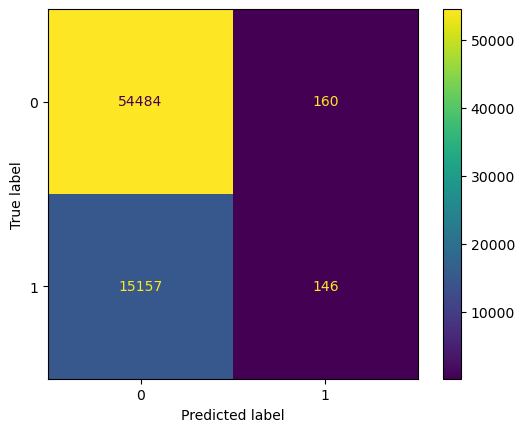



Accuracy:  0.7759017541853117
Precision:  0.393348623853211
Recall:  0.04482781154022087
F1: 0.08048336950783129
AUC:  <function auc at 0x000002D8E4DC3A60>


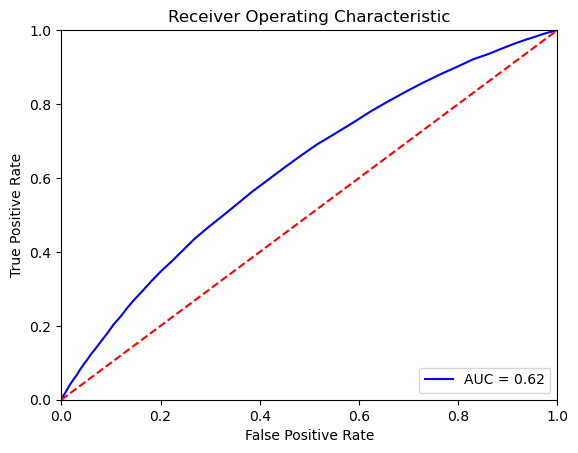

C:\Users\Thanh Le\AppData\Local\Temp\ipykernel_13888\876954425.py:35: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(results_df[results_df['true_class'] == 0]['default_prob'], label = 'No Default', hist = False)
C:\Users\Thanh Le\AppData\Local\Temp\ipykernel_13888\876954425.py:36: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/

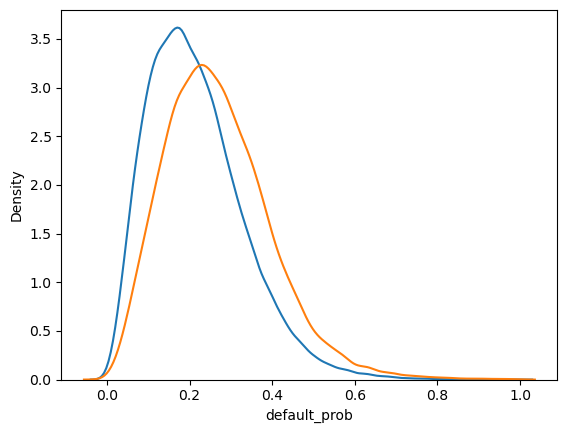

true_class  predicted_class
0           0                  0.980638
            1                  0.019362
1           0                  0.955172
            1                  0.044828
Name: proportion, dtype: float64


In [38]:
#type solution here
rfc_model = RandomForestClassifier()
rfc_model.fit(x_train, y_train)
eval_model(rfc_model, x_test, y_test)

Let's take a minute to interpret these results 

### Accuracy 

- ~78% similar to the simple logistic regression model we built already

### Precision 

- 39% better than simple logistic Regression which had ~33% 
- More of the instances we classified as defaults actually were defaults 
- However, most of the instances we classify as defaults are actually not defaults

### Recall 

- Recall has increased dramatically, from 0.03% to 4.5%!
- Random Forest picked up a lot more of the actual positive cases
- It still missed most of them

### F1

- The F1 score has also increased dramatically from 0.0006 to ~0.08! 
- There is a better balance between Precision and Recall for Random Forest
- Although this is still generally poor

### AUC 

- The area under the roc curve has increased very slightly

### Probability Distributions 

- Plot shows bad class separation 
- Majority of cases unlikely to be classified as defaults 

Generally the random forest is better than Logistic Regression but it is still not doing a good job

## Lesson 2 - Overfitting

A model is said to be overfitted if it performs very well on training data but does not generalize well to unseen test data

We can look at evaluate our model's performance on the training data to investigate overfitting

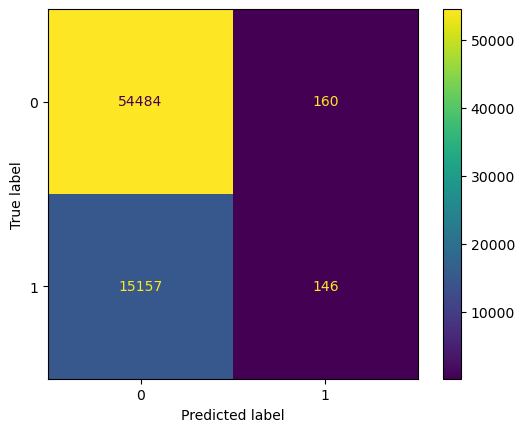



Accuracy:  0.9996691318387079
Precision:  0.999405031731641
Recall:  0.9990653676220687
F1: 0.999235170811852
AUC:  <function auc at 0x000002D8E4DC3A60>


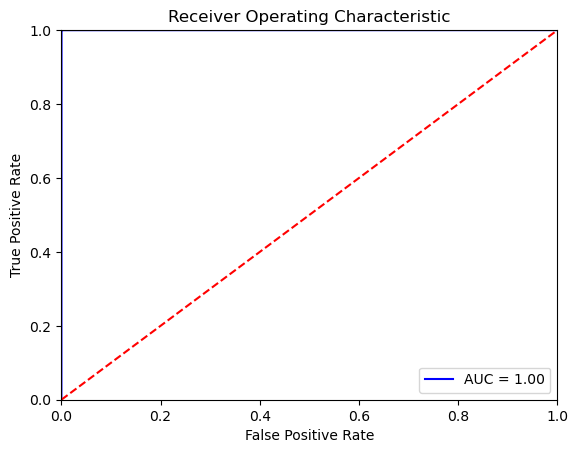

C:\Users\Thanh Le\AppData\Local\Temp\ipykernel_13888\876954425.py:35: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(results_df[results_df['true_class'] == 0]['default_prob'], label = 'No Default', hist = False)
C:\Users\Thanh Le\AppData\Local\Temp\ipykernel_13888\876954425.py:36: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/

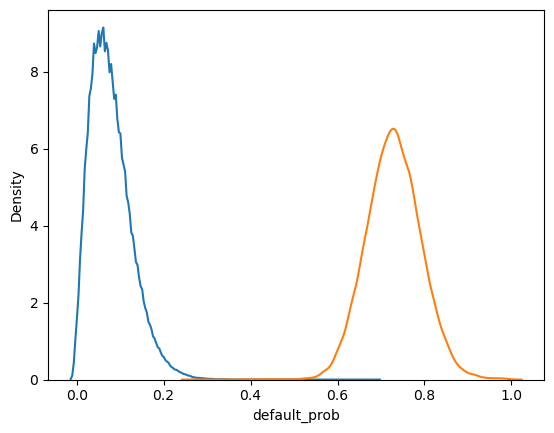

true_class  predicted_class
0           0                  0.999836
            1                  0.000164
1           1                  0.999065
            0                  0.000935
Name: proportion, dtype: float64


In [39]:
#eval on training data
eval_model(rfc_model, x_train, y_train)

Wow! Pretty clear evidence that our random forest is overfitting, it has nearly perfect results on the training data and poor results on the test data

## Lesson 3 - Hyperparameters 

Classification performance of random forest can be heavily influenced by its hyperparameters

### Hyperparameter Tuning 

- The process of selecting optimal hyperparameters 
- Can be tricky and time-consuming, many automated methods exists for finding the parameters that yield the best classification results 
- Out of scope of this course but if you are interested look at [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

### Number of Trees
- How big is the forest?
- Typically increasing the number of trees increases model performance up to a certain point
- Too many trees can increase the computational cost and does little to benefit classification performance
- set through the n_estimators property

### Maximum Depth
- The longest path between a tree root node and its deepest leaf node
- exposed through max_depth parameter which defaults to None, meaning the max depth is not limited
- limiting the depth of the trees can be used to reduce overfitting


 



### Number of Trees 

Let's do some manual exploration of the forest size parameter, remember the default value is 100 

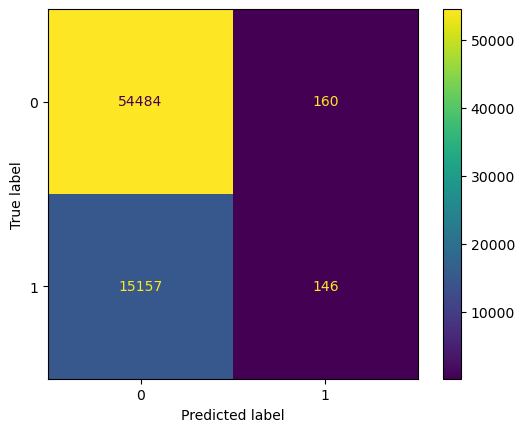



Accuracy:  0.6692209816003546
Precision:  0.25818002222496605
Recall:  0.27327974906881003
F1: 0.2655153804641122
AUC:  <function auc at 0x000002D8E4DC3A60>


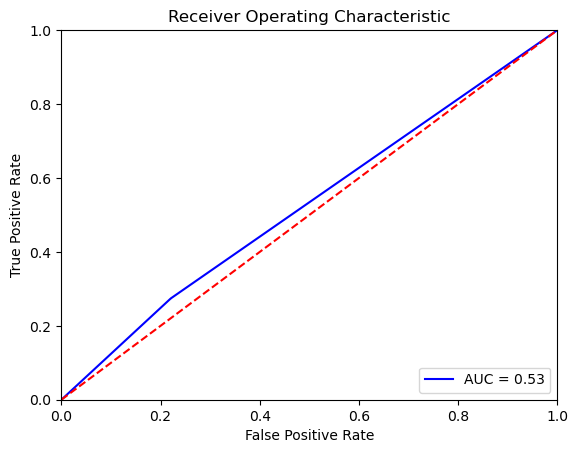

C:\Users\Thanh Le\AppData\Local\Temp\ipykernel_13888\876954425.py:35: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(results_df[results_df['true_class'] == 0]['default_prob'], label = 'No Default', hist = False)
C:\Users\Thanh Le\AppData\Local\Temp\ipykernel_13888\876954425.py:36: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/

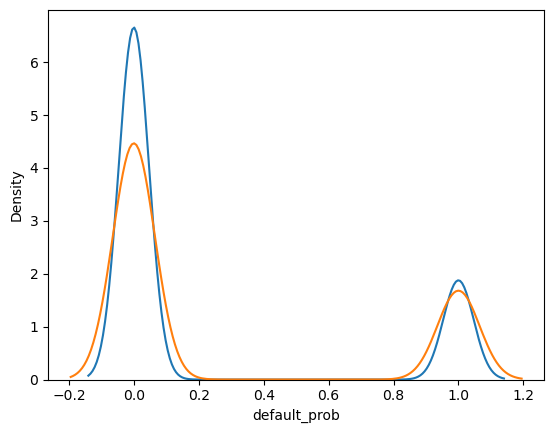

true_class  predicted_class
0           0                  0.780104
            1                  0.219896
1           0                  0.726720
            1                  0.273280
Name: proportion, dtype: float64


In [40]:
# 1 estimator
rfc_model = RandomForestClassifier(n_estimators=1)
rfc_model.fit(x_train, y_train)

eval_model(rfc_model, x_test, y_test)

- With a forest size of 1, the random forest behaves as a standalone decision tree and is unable to distinguish between the two classes
- With AUC of 0.52 it is only marginally better than a random classifier

Let's see what happens if we increase the number of trees to 10

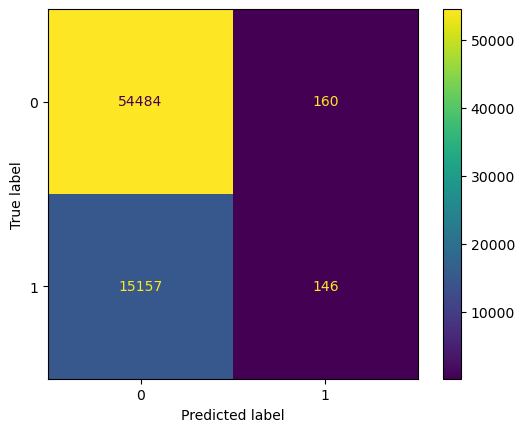



Accuracy:  0.7675239824438503
Precision:  0.35279655808236016
Recall:  0.07501797033261452
F1: 0.12372689551112787
AUC:  <function auc at 0x000002D8E4DC3A60>


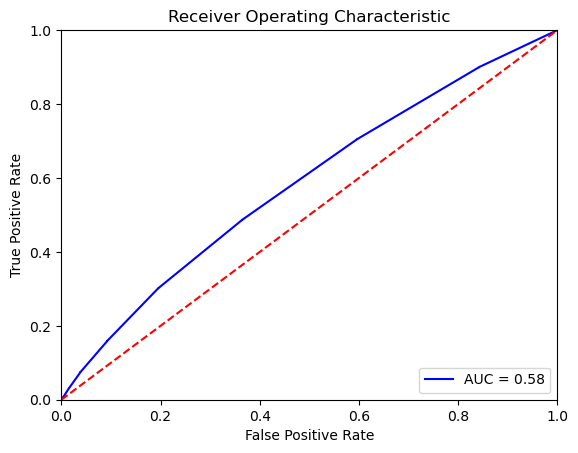

C:\Users\Thanh Le\AppData\Local\Temp\ipykernel_13888\876954425.py:35: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(results_df[results_df['true_class'] == 0]['default_prob'], label = 'No Default', hist = False)
C:\Users\Thanh Le\AppData\Local\Temp\ipykernel_13888\876954425.py:36: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/

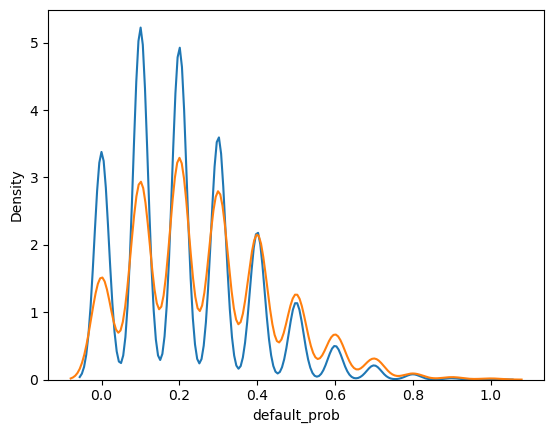

true_class  predicted_class
0           0                  0.961460
            1                  0.038540
1           0                  0.924982
            1                  0.075018
Name: proportion, dtype: float64


In [41]:
#10 estimators
rfc_model = RandomForestClassifier(n_estimators=10)
rfc_model.fit(x_train, y_train)

eval_model(rfc_model, x_test, y_test)

- We see here that with a forest size of 10 the separation ability of the model increases with an AUC of 0.58
- Multiple peaks on the distribution chart suggest that this is not a very stable model

How about with the default value of 100 trees?

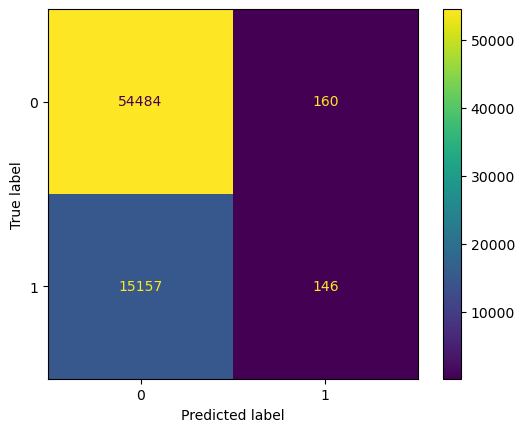



Accuracy:  0.7759160507241197
Precision:  0.3928365106874639
Recall:  0.04443573155590407
F1: 0.07984031936127745
AUC:  <function auc at 0x000002D8E4DC3A60>


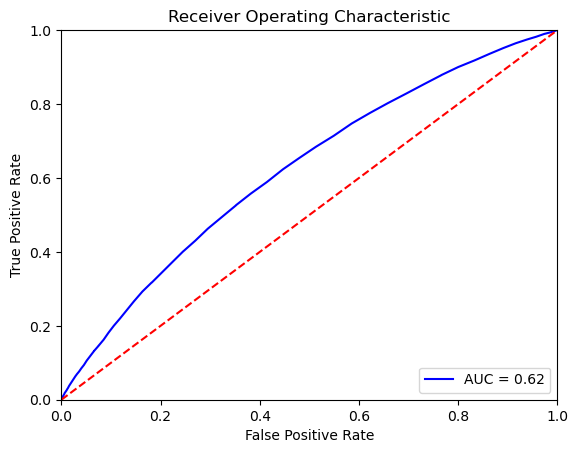

C:\Users\Thanh Le\AppData\Local\Temp\ipykernel_13888\876954425.py:35: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(results_df[results_df['true_class'] == 0]['default_prob'], label = 'No Default', hist = False)
C:\Users\Thanh Le\AppData\Local\Temp\ipykernel_13888\876954425.py:36: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/

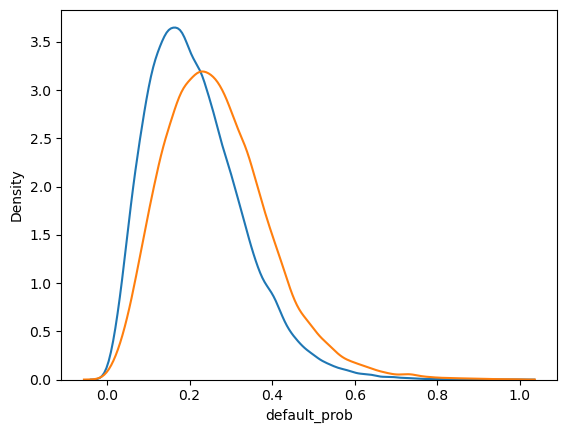

true_class  predicted_class
0           0                  0.980766
            1                  0.019234
1           0                  0.955564
            1                  0.044436
Name: proportion, dtype: float64


In [42]:
#100 estimators
rfc_model = RandomForestClassifier(n_estimators=100)
rfc_model.fit(x_train, y_train)

eval_model(rfc_model, x_test, y_test)

- With 100 estimators the AUC improved from 0.58 to 0.62
- Class distributions appeared more defined and settled

What about if we increase to 300?

*NB - You might not be able to run all the scenarios due to system capacity. If you receive a "MemoryError", it means the model is too expensive to run on your computer. Try reducing n_estimators to 200 or 150.*

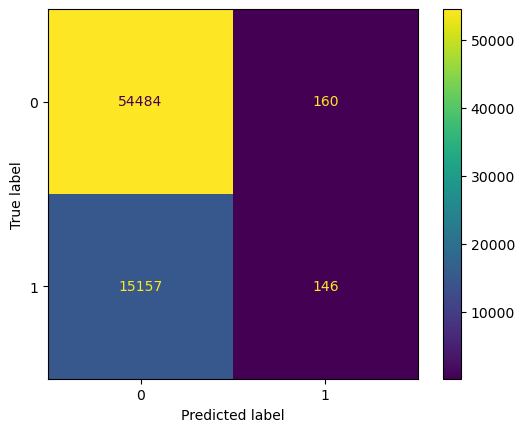



Accuracy:  0.7763020572719345
Precision:  0.3935643564356436
Recall:  0.041560478337580864
F1: 0.07518174833027957
AUC:  <function auc at 0x000002D8E4DC3A60>


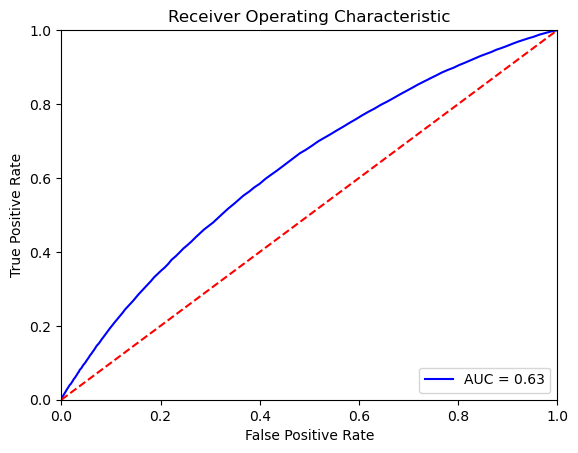

C:\Users\Thanh Le\AppData\Local\Temp\ipykernel_13888\876954425.py:35: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(results_df[results_df['true_class'] == 0]['default_prob'], label = 'No Default', hist = False)
C:\Users\Thanh Le\AppData\Local\Temp\ipykernel_13888\876954425.py:36: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/

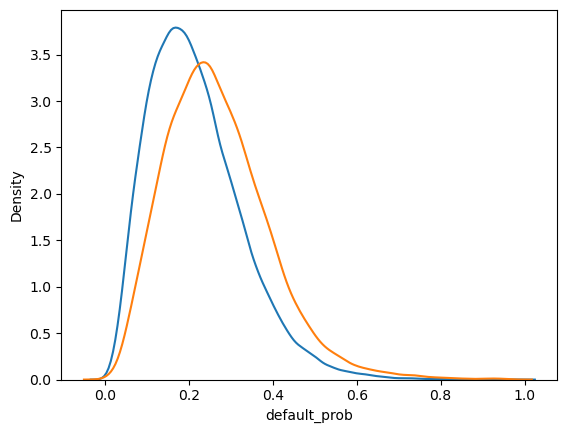

true_class  predicted_class
0           0                  0.982066
            1                  0.017934
1           0                  0.958440
            1                  0.041560
Name: proportion, dtype: float64


In [43]:
#300 estimators
rfc_model = RandomForestClassifier(n_estimators=300)
rfc_model.fit(x_train, y_train)

eval_model(rfc_model, x_test, y_test)

Very similar performance to the default value of 100! 

Increasing the size of the forest helps classification performance up to a point

However, it also increases the computational cost of training the model

### Maximum Depth

We observed earlier that our random forest model is overfitting

One way of tackling overfitting in random forest is by limiting the Maximum Depth of the trees. This prevents the classifiers from growing to large picking up noise in the training data

The default value of max_depth is None (it is not limited!)

Let's do some experiments

*NB - You might not be able to run all the scenarios due to system capacity. If you receive a "MemoryError", it means the model is too expensive to run on your computer.*

d:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


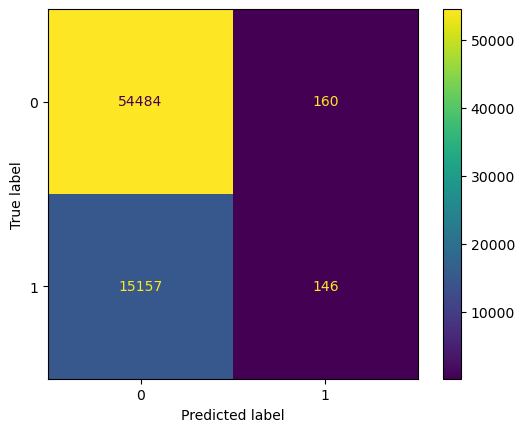



Accuracy:  0.7812200666218708
Precision:  0.0
Recall:  0.0
F1: 0.0
AUC:  <function auc at 0x000002D8E4DC3A60>


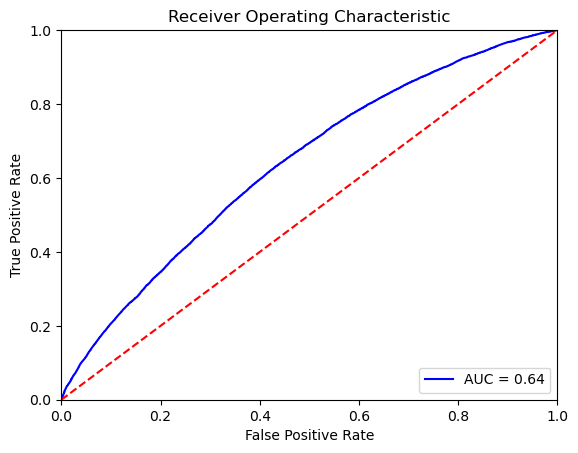

C:\Users\Thanh Le\AppData\Local\Temp\ipykernel_13888\876954425.py:35: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(results_df[results_df['true_class'] == 0]['default_prob'], label = 'No Default', hist = False)
C:\Users\Thanh Le\AppData\Local\Temp\ipykernel_13888\876954425.py:36: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/

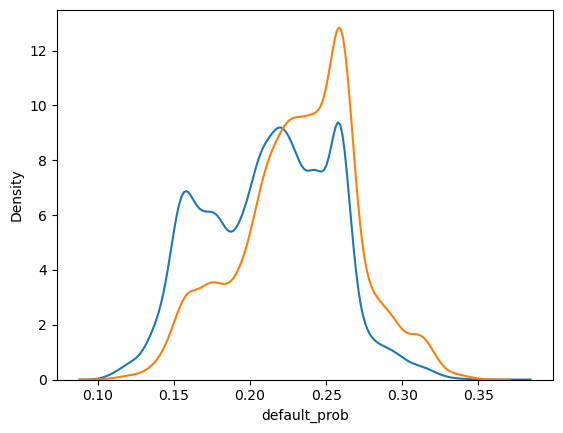

true_class  predicted_class
0           0                  1.0
1           0                  1.0
Name: proportion, dtype: float64


In [44]:
#max depth 5
rfc_model = RandomForestClassifier(n_estimators=100, max_depth=5)
rfc_model.fit(x_train, y_train)

eval_model(rfc_model, x_test, y_test)

We have increased the AUC but the model is failing to identify any loan defaults

Let's take a look at how it performs on the training data

d:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


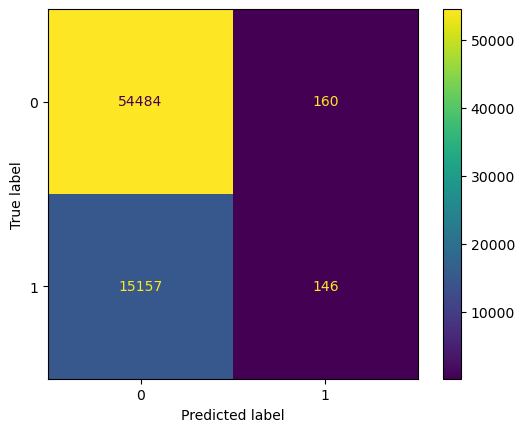



Accuracy:  0.7836612400203423
Precision:  0.0
Recall:  0.0
F1: 0.0
AUC:  <function auc at 0x000002D8E4DC3A60>


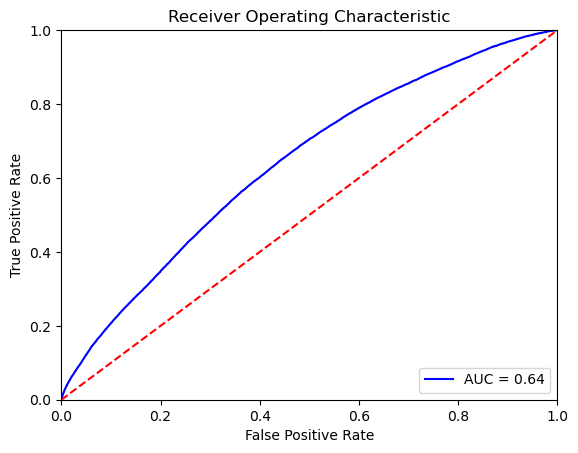

C:\Users\Thanh Le\AppData\Local\Temp\ipykernel_13888\876954425.py:35: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(results_df[results_df['true_class'] == 0]['default_prob'], label = 'No Default', hist = False)
C:\Users\Thanh Le\AppData\Local\Temp\ipykernel_13888\876954425.py:36: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/

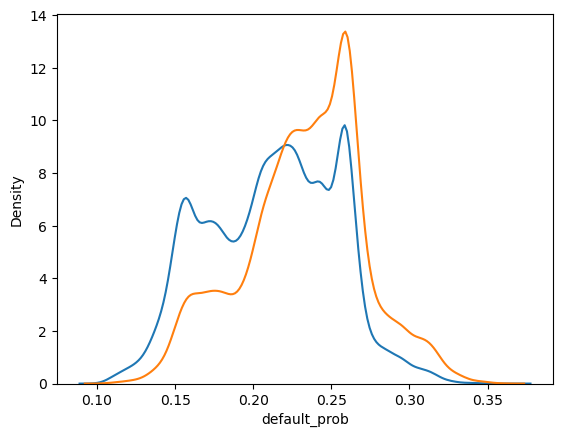

true_class  predicted_class
0           0                  1.0
1           0                  1.0
Name: proportion, dtype: float64


In [45]:
#check the overfitting
eval_model(rfc_model, x_train, y_train)

As with the test data, the model is not identifying any defaults.

Very similar performance between training and test data tells us we are not overfitting anymore, but the model has very little predictive power

Limiting the tree size to 5 has probably oversimplified the model and actually given us an underfit model!

Let's try again with a larger max_depth

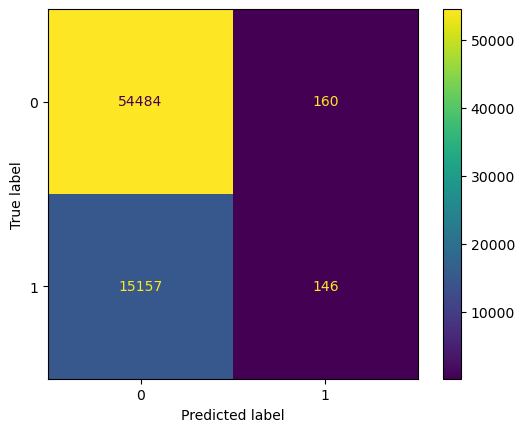



Accuracy:  0.7816489627861095
Precision:  0.631578947368421
Recall:  0.004704959811801608
F1: 0.009340338587273789
AUC:  <function auc at 0x000002D8E4DC3A60>


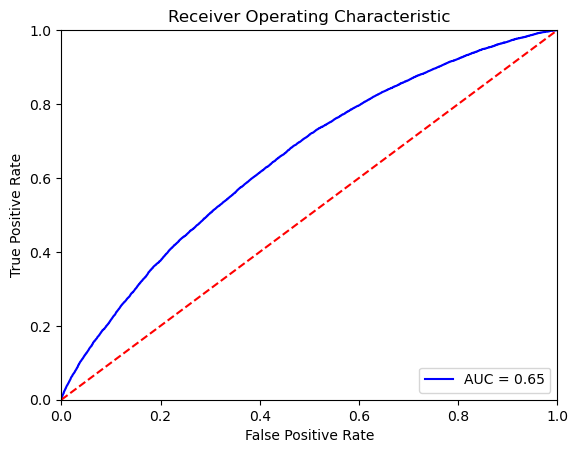

C:\Users\Thanh Le\AppData\Local\Temp\ipykernel_13888\876954425.py:35: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(results_df[results_df['true_class'] == 0]['default_prob'], label = 'No Default', hist = False)
C:\Users\Thanh Le\AppData\Local\Temp\ipykernel_13888\876954425.py:36: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/

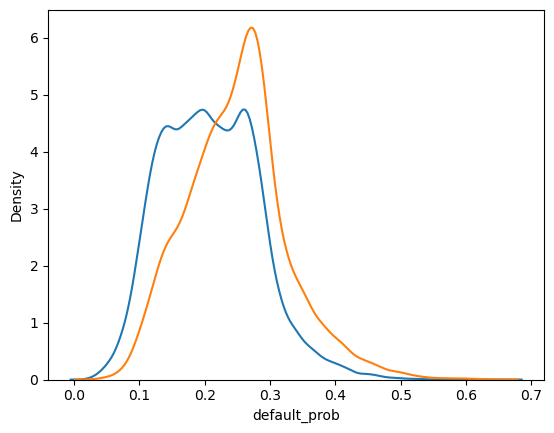

true_class  predicted_class
0           0                  0.999231
            1                  0.000769
1           0                  0.995295
            1                  0.004705
Name: proportion, dtype: float64


In [46]:
#max depth 15
rfc_model = RandomForestClassifier(n_estimators=100, max_depth=15)
rfc_model.fit(x_train, y_train)

eval_model(rfc_model, x_test, y_test)

A few things to note here! 

We have increased the AUC to ~0.65, this model has the best ability to separate classes that we have seen so far! 

It is also has a very good precision score of 67%, but we are still identifying very few loan defaults hence the poor recall

Let's have a look at the training set performance!

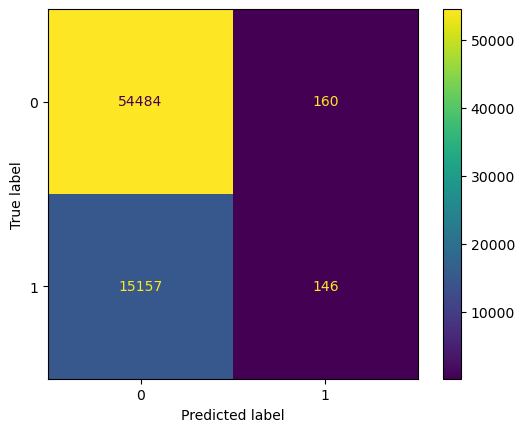



Accuracy:  0.7941142230419038
Precision:  0.9942062572421785
Recall:  0.048600883652430045
F1: 0.09267159907112384
AUC:  <function auc at 0x000002D8E4DC3A60>


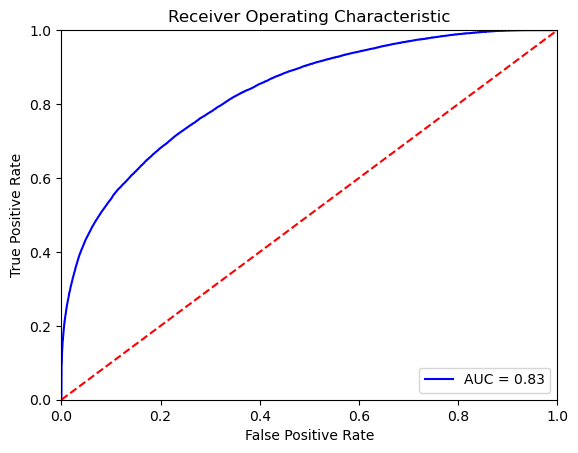

C:\Users\Thanh Le\AppData\Local\Temp\ipykernel_13888\876954425.py:35: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(results_df[results_df['true_class'] == 0]['default_prob'], label = 'No Default', hist = False)
C:\Users\Thanh Le\AppData\Local\Temp\ipykernel_13888\876954425.py:36: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/

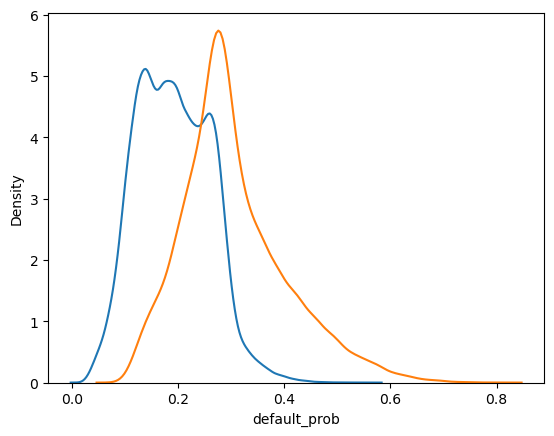

true_class  predicted_class
0           0                  0.999922
            1                  0.000078
1           0                  0.951399
            1                  0.048601
Name: proportion, dtype: float64


In [47]:
#check the overfitting
eval_model(rfc_model, x_train, y_train)

Our model does perform better on the training data so it could be a little overfitted. However, it certainly is much less dramatic than before! 

We have now limited the complexity of the trees in our forest which has reduced overfitting. 

### A Note on Hyperparameter Tuning 

- We have discussed the effects of n_estimators and max_depth in isolation 
- Random Forest has many more parameters that can be tuned 
- In reality, parameters are dependent on each other, i.e changing one affects the others
- Automated methods to find the right balance exist, look at [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)